# 第四章 截面预测

## 4.1 导言

在上一章中，我们了解到了，对于时间序列上的预测，我们应当如何计算精炼预测。
但是，当我们处理的是截面分值，而非时间序列上的标准分值时，我们将会面临一些新的困难。
事实上，即使是时间序列上的预测，在多资产预测的情形下，仍然可以看作截面预测。
所以，针对截面预测的处理方式，更具有普遍性和一般性。

在本章中，我们将以一个截面信号的预测为例，详细介绍如何处理截面信号，怎样由截面信号得出精炼预测。

## 4.2 基础知识准备

这里，我们将介绍，如何处理截面预测。同前面的章节一样，我们省略掉大部分数学推导，仅介绍结论及其意义。

首先，我们要指出，前文提到的公式也适用于多资产情形：
$$\alpha = \mathbf{Cov}[r, g] \cdot \mathbf{Var}^{-1}[g] \cdot (g - \mathbf{E}[g])$$
$$\alpha_n = \omega_n \cdot IC \cdot z_{TS,n}$$

这里，我们不得不提到一个重要的假设：我们假设每只资产的预测具有相同的信息系数IC，即
$$IC_n = IC, \forall n$$

乍一听，这个假设不太合理。但仔细一想，如果不同资产具有不同的IC，那么，我们可以把这种不同找出来，做成信号的一部分，这样，我们的预测不就更准确了吗？换言之，既然我们已经开始使用这个信号，那么，这意味着，我们已经把不同资产在IC上的不同性质充分考虑了。所以，这个假设是合理的。

另外，我们在上面特别标注了TS，这是代表“时间序列”的意思，目的是与后文的CS标记相区分，CS代表“截面序列”的意思。
这里，我们强调了前面的z分值，是通过时间序列数据算出来的：
$$z_{TS,n}(t) = \frac{g_n(t) - \mathbf{E}_{TS}[g_n]}{\mathbf{Std}_{TS}[g_n]}$$
这和下文的截面z分值相区分：
$$z_{CS,n}(t) = \frac{g_n(t) - \mathbf{E}_{CS}[g_n]}{\mathbf{Std}_{CS}[g_n]}$$

做数学的人，面对如此难题时，第一反应往往是把截面z分值转化为时间序列的z分值。
事实也正是如此，经过研究发现，在转化过程中，我们需要一些假设。
在不同的假设下，转化方式往往不同。我们选取了两种常见假设，把转化结果列在下面。

### 4.2.1 不同股票具有相同的时间序列信号波动率

在这个假设下，截面的z分值等于时间序列的z分值。
通过时间序列数据得到的精炼预测也等于通过截面数据得到的精炼预测。
此时，
$$\alpha_n = \omega_n \cdot IC \cdot z_{TS,n} = \omega_n \cdot IC \cdot z_{CS,n}$$

我们来检视一下，上一章中的“红三兵”是否具有这种性质？由于红三兵只要求三根阳线，并不认为阳线长的就比阳线短的分值更高。
所以，看起来它的分值应该和股票本身的波动率无关。那么，我们可以大致认为它具有这种性质。
所以，上一章的计算，仍然是科学的，我们的努力并没有白费。

### 4.2.2 时间序列信号波动率与股票波动率成正比

这个假设相对更为常见，许多时候，我们在构造信号时，会不自觉的加入一些观点，比如过去涨得快的，未来也涨得快。
这就会导致我们的信号具有特点：信号波动率与股票波动率正相关。
我们为了简化问题，就假设它们成正比：
$$ \mathbf{Std}_{TS}[g_n] = c \cdot \omega_n $$
其中，$\mathbf{Std}_{TS}[g_n]$是对第n只股票的原始预测$g_n$在时间序列上的波动率，$\omega_n$是股票n的主动收益率的波动率，$c$是一个常数。

那么，我们可以如下估计这个常数：
$$c = \mathbf{Std}_{TS}[\frac{g_n}{\omega_n}]$$

在这个假设下，我们通过截面数据得到的精炼预测变成了：
$$\alpha_n = IC \cdot \frac{\mathbf{Std}_{CS}[g_n]}{c} \cdot z_{CS,n}$$

这个c只与信号g相关，不同信号的c不同，相同信号的c在股票间以及在时间上都相同。这个性质非常好。
有兴趣的读者可以自己推一推上述公式。

## 4.3 操作总览

本实验由以下几个步骤组成：
1. 步骤一：构造动量信号作为原始预测并标准化
2. 步骤二：研究动量信号的波动率特征
3. 步骤三：多角度计算信息系数IC
4. 步骤四：计算精炼预测$\alpha$

## 4.4 操作流程

### 4.4.0 准备工作

和前面的章节一样，本章的代码也是可以独立运行的，所以我们需要先做一些准备工作。

首先，我们导入包：

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tushare as ts

然后我们获取股票数据和上证50指数数据：

In [4]:
stock_list = ts.get_sz50s().code
stock_data = {}
for stock in stock_list:
    stock_data[stock] = ts.get_k_data(stock, start='2017-01-01', end='2017-12-31')
    
index_name = '000016'
index_data = ts.get_k_data(index_name, index=True, start='2017-01-01', end='2017-12-31')

/home/zjc/anaconda3/lib/python3.6/site-packages/tushare/stock/classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


整理数据：

In [5]:
#整理股票数据
stock_0 = pd.DataFrame(index=index_data.date)
stock_na = pd.DataFrame(index=index_data.date)
stock_open = stock_0.copy()
stock_high = stock_0.copy()
stock_low = stock_0.copy()
stock_close = stock_0.copy()

for stock in stock_list:
    stock_0 = stock_0.join(pd.DataFrame(0.0, index=stock_data[stock].date, columns=[stock]))
    stock_na = stock_na.join(pd.DataFrame(stock_data[stock].open.isna().values, index=stock_data[stock].date, columns=[stock]))
    stock_open = stock_open.join(pd.DataFrame(stock_data[stock].open.values, index=stock_data[stock].date, columns=[stock]))
    stock_high = stock_high.join(pd.DataFrame(stock_data[stock].high.values, index=stock_data[stock].date, columns=[stock]))
    stock_low = stock_low.join(pd.DataFrame(stock_data[stock].low.values, index=stock_data[stock].date, columns=[stock]))
    stock_close = stock_close.join(pd.DataFrame(stock_data[stock].close.values, index=stock_data[stock].date, columns=[stock]))
    
stock_rtn = stock_0.copy()
for stock in stock_list:
    stock_rtn[stock] = stock_close[stock] / stock_close[stock].shift() - 1
stock_rtn = stock_rtn.fillna(0)

#整理指数数据
index_0 = pd.DataFrame(0.0, index=index_data.date, columns=[index_name])
index_open = pd.DataFrame(index_data.open.values, index=index_data.date, columns=[index_name])
index_high = pd.DataFrame(index_data.high.values, index=index_data.date, columns=[index_name])
index_low = pd.DataFrame(index_data.low.values, index=index_data.date, columns=[index_name])
index_close = pd.DataFrame(index_data.close.values, index=index_data.date, columns=[index_name])

index_rtn = index_close / index_close.shift() - 1
index_rtn = index_rtn.fillna(0)

#计算主动收益率
stock_active_rtn = stock_rtn - np.repeat(index_rtn.values, stock_rtn.columns.size, axis=1)

以上，我们完成了本章的准备工作，其主要是整理上一章的相关内容。

### 4.4.1 步骤一：构造动量信号作为原始预测并标准化

本章的主题是截面信号，我们选取动量信号作为截面信号的代表。我们的构造方式如下：
1. 计算收盘价的3日均线和13日均线
2. 计算3日均线超过13日均线的部分相对于13日均线的比例
3. 统计股票池中所有股票的上述比例，给股票排名
4. 标准化上述排名

本步骤与上一章由相似之处，也可以作为对上一章的复习。

首先，我们来计算3日均线：

In [7]:
stock_ma3 = (stock_close + stock_close.shift() + stock_close.shift(2)) / 3
print(stock_ma3.head())

               600000    600016  600019    600028    600029     600030  \
date                                                                     
2017-01-03        NaN       NaN     NaN       NaN       NaN        NaN   
2017-01-04        NaN       NaN     NaN       NaN       NaN        NaN   
2017-01-05  12.258667  7.227333   5.923  4.942333  6.918333  15.466333   
2017-01-06  12.228667  7.201000   6.003  5.048333  6.957333  15.409000   
2017-01-09  12.196000  7.177333   6.055  5.133667  6.983333  15.361333   

               600036    600048    600050     600104    ...     601766  \
date                                                    ...              
2017-01-03        NaN       NaN       NaN        NaN    ...        NaN   
2017-01-04        NaN       NaN       NaN        NaN    ...        NaN   
2017-01-05  16.882333  8.655333  7.539333  21.635667    ...      9.498   
2017-01-06  16.882333  8.645667  7.619000  21.641667    ...      9.530   
2017-01-09  16.857667  8.636000  7.71

上述算法简单而有效，但不足之处在于，对于像均线这样常用而且参数经常g变化的技术指标来说，每次都这样单独写一段程序计算，略嫌麻烦。更好的方式是写一个函数，把均线的参数设计为函数的参数，这样，就更方便我们计算了：

In [10]:
def ma_calculator(data, n):
    res = data.copy()
    for i in range(1, n):
        res += data.shift(i)
    return res / n

这样，我们可以更方便的计算均线了：

In [11]:
stock_ma3 = ma_calculator(stock_close, 3)
stock_ma13 = ma_calculator(stock_close, 13)
print(stock_ma3.head())

               600000    600016  600019    600028    600029     600030  \
date                                                                     
2017-01-03        NaN       NaN     NaN       NaN       NaN        NaN   
2017-01-04        NaN       NaN     NaN       NaN       NaN        NaN   
2017-01-05  12.258667  7.227333   5.923  4.942333  6.918333  15.466333   
2017-01-06  12.228667  7.201000   6.003  5.048333  6.957333  15.409000   
2017-01-09  12.196000  7.177333   6.055  5.133667  6.983333  15.361333   

               600036    600048    600050     600104    ...     601766  \
date                                                    ...              
2017-01-03        NaN       NaN       NaN        NaN    ...        NaN   
2017-01-04        NaN       NaN       NaN        NaN    ...        NaN   
2017-01-05  16.882333  8.655333  7.539333  21.635667    ...      9.498   
2017-01-06  16.882333  8.645667  7.619000  21.641667    ...      9.530   
2017-01-09  16.857667  8.636000  7.71

以上的均线是用简单移动平均法计算出来的，而计算均线的方法还有很多，常用的有指数加权移动平均等，我们把这个作为课堂练习，交由读者完成：

In [32]:
#设计函数，计算指数加权移动平均线
def ewma_calculator(data, n, alpha):
    res = data.copy()
    index_list = res.index
    for i in range(len(index_list)):
        if i > 0:
            res.loc[index_list[i]] = res.loc[index_list[i]] * alpha + res.loc[index_list[i-1]] * (1-alpha)
    return res
stock_ma3 = ewma_calculator(stock_close, 3, 0.9)
print(stock_ma3.head())

               600000    600016    600019    600028    600029     600030  \
date                                                                       
2017-01-03  12.251000  7.235000  5.846000  4.854000  6.853000  15.470000   
2017-01-04  12.271700  7.235000  5.945900  4.901700  6.915100  15.495200   
2017-01-05  12.253070  7.214300  5.963990  5.049570  6.973510  15.437420   
2017-01-06  12.170207  7.161830  6.073799  5.159757  6.970351  15.311942   
2017-01-09  12.175421  7.163783  6.109080  5.162676  6.997035  15.350694   

               600036    600048    600050     600104    ...       601766  \
date                                                    ...                
2017-01-03  16.820000  8.649000  7.410000  21.468000    ...     9.447000   
2017-01-04  16.870400  8.666100  7.401000  21.791100    ...     9.533400   
2017-01-05  16.942940  8.650710  7.767300  21.629910    ...     9.506940   
2017-01-06  16.832294  8.623071  7.660830  21.500391    ...     9.539394   
2017-01-09 

接下来，我们计算3日均线超过13日均线的比例：

In [38]:
stock_ma_excess = stock_ma3 / stock_ma13 - 1
stock_ma_excess = stock_ma_excess.fillna(0.0)
print(stock_ma_excess.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.008585 -0.009256  0.000569  0.001819  0.046052 -0.005817   
2017-12-26 -0.008232 -0.007885 -0.002641  0.006952  0.055244 -0.000969   
2017-12-27 -0.006369 -0.005047 -0.004753  0.009914  0.055893 -0.000889   
2017-12-28 -0.005080 -0.005764  0.006753  0.016281  0.048762  0.002914   
2017-12-29 -0.005445 -0.010147  0.015659  0.018957  0.027694 -0.001968   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.020183  0.043338 -0.030244  0.007154    ...    -0.037277   
2017-12-26  0.017032  0.058419 -0.030176  0.007426    ...    -0.043167   
2017-12-27  0.010287  0.067452 -0.030932  0.003066    ...    -0.047154   
2017-12-28  0.003491  0.066489 -0.029039 -0.002237    ...    -0.040409   
2017-12-29 -0.006227  0.064165 -0.036

接下来，我们需要在每天按上述比例给股票排名，然后将排名标准化。有读者可能会产生一个疑问，为什么不直接把上述比例作为原始预测？

实际上，这并非不可以。只是，我们需要考虑到，我们要选的，并非仅仅只是要涨的股票，而更应该选择比业绩基准涨得更好的股票。那么，我们就需要在股票间横向比较每个指标。

那么，具体怎么标准化呢？一个简单而合理的方法是：以排名的分位数作为正态分布的分位数，将排名映射为标准正态分布上的一个值。
那我们先来计算排名：

In [39]:
stock_ma_excess_rank = stock_ma_excess.rank(axis=1)
print(stock_ma_excess_rank.tail())

            600000  600016  600019  600028  600029  600030  600036  600048  \
date                                                                         
2017-12-25    16.0    13.0    28.0    29.0    49.0    19.0    39.0    48.0   
2017-12-26    12.0    13.0    21.0    33.0    49.0    22.0    39.0    50.0   
2017-12-27    15.0    17.0    18.0    39.0    49.0    23.0    40.0    50.0   
2017-12-28    18.0    17.0    32.0    42.0    49.0    30.0    31.0    50.0   
2017-12-29    23.0    18.0    37.0    41.0    45.0    26.0    21.0    50.0   

            600050  600104   ...    601688  601766  601800  601818  601857  \
date                         ...                                             
2017-12-25     5.0    34.0   ...       3.0    41.0     8.0    12.0    33.0   
2017-12-26     5.0    34.0   ...       3.0    47.0    10.0    14.0    35.0   
2017-12-27     5.0    28.0   ...       3.0    48.0     8.0    19.0    36.0   
2017-12-28     5.0    24.0   ...       3.0    47.0     7.0    2

然后，我们把排名转化为分位数，比如，我们有50只股票，则排第一名的（即最小的）股票的分位数为1/51。

In [40]:
stock_ma_excess_quantile = stock_ma_excess_rank / (stock_list.size + 1)
print(stock_ma_excess_quantile.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25  0.313725  0.254902  0.549020  0.568627  0.960784  0.372549   
2017-12-26  0.235294  0.254902  0.411765  0.647059  0.960784  0.431373   
2017-12-27  0.294118  0.333333  0.352941  0.764706  0.960784  0.450980   
2017-12-28  0.352941  0.333333  0.627451  0.823529  0.960784  0.588235   
2017-12-29  0.450980  0.352941  0.725490  0.803922  0.882353  0.509804   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.764706  0.941176  0.098039  0.666667    ...     0.058824   
2017-12-26  0.764706  0.980392  0.098039  0.666667    ...     0.058824   
2017-12-27  0.784314  0.980392  0.098039  0.549020    ...     0.058824   
2017-12-28  0.607843  0.980392  0.098039  0.470588    ...     0.058824   
2017-12-29  0.411765  0.980392  0.078

然后，我们把这个分位数看作正态分布的分位数，将其映射到一个正态分布上。比如，分位数为0.5的就映射到0，分位数为0.95的，就映射到1.64。
这里需要用到SciPy这个包，我们这里先使用它，在本章的末尾，我们在详细介绍这个包。

In [52]:
import scipy as sp
import scipy.stats
rtn_predictor_ma = stock_ma_excess_quantile.apply(sp.stats.norm(0,1).ppf)
print(rtn_predictor_ma.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.485318 -0.659143  0.123185  0.172881  1.759861 -0.325110   
2017-12-26 -0.721522 -0.659143 -0.223008  0.377392  1.759861 -0.172881   
2017-12-27 -0.541395 -0.430727 -0.377392  0.721522  1.759861 -0.123185   
2017-12-28 -0.377392 -0.430727  0.325110  0.928899  1.759861  0.223008   
2017-12-29 -0.123185 -0.377392  0.599230  0.855712  1.186831  0.024577   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.721522  1.564726 -1.292805  0.430727    ...    -1.564726   
2017-12-26  0.721522  2.061917 -1.292805  0.430727    ...    -1.564726   
2017-12-27  0.786845  2.061917 -1.292805  0.123185    ...    -1.564726   
2017-12-28  0.273702  2.061917 -1.292805 -0.073791    ...    -1.564726   
2017-12-29 -0.223008  2.061917 -1.415

这样，我们就得到了动量信号的原始预测，并初步进行了标准化。

### 4.4.2 步骤二：研究动量信号的波动率特征

前面，我们对动量信号进行过一次初步的标准化。为什么叫“初步”呢？因为，我们是在截面标准化的，在时间序列层面，不同股票的动量信号可能波动率完全不同。我们先作个图来看看：

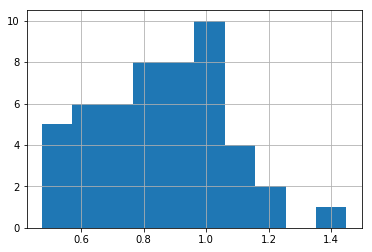

In [62]:
rtn_predictor_ma_std = rtn_predictor_ma.std()
rtn_predictor_ma_std.hist()
plt.show()

可以看出，不同股票间，动量信号的波动率分布在0.4到1.5之间，相差较大。
那么，导致这种差异的原因是什么？一个自然的想法是，不同股票的主动收益本来就分布不同，有的波动大，有的波动小。
这自然导致其动量信号也是同样，有的波动大，有的波动小。
那我们可以画图对比一下，我们先画不同股票信号波动率的柱状图：

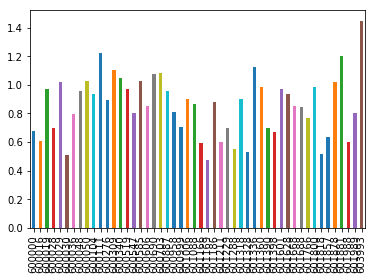

In [63]:
rtn_predictor_r3s_std.plot(kind='bar')
plt.show()

接着，我们画不同股票主动收益的波动率的柱状图：

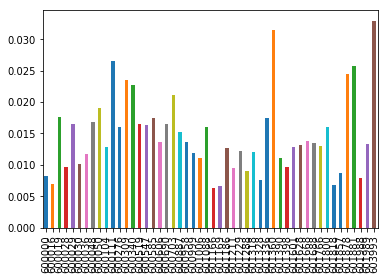

In [64]:
stock_active_rtn_std = stock_active_rtn.std()
stock_active_rtn_std.plot(kind='bar')
plt.show()

从以上两个图中，我们可以粗略看出，确实前面说的性质，波动率本来就较高的股票，其动量信号的波动率也较高。
那么，二者之间有没有什么相对确定性的关系呢？我们先作个相关关系的散点图：

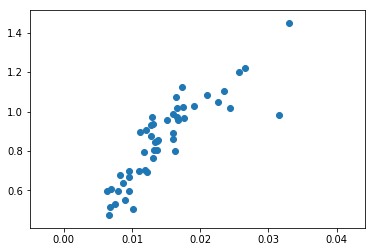

In [66]:
plt.scatter(stock_active_rtn_std, rtn_predictor_ma_std)
plt.show()

很明显，两个变量间，相关性很强，有一定的线性关系，我们做个简单的回归分析：

In [77]:
print(sp.stats.linregress(stock_active_rtn_std, rtn_predictor_ma_std))

LinregressResult(slope=29.656051530988286, intercept=0.41949068275468737, rvalue=0.8677773409857773, pvalue=3.4752638985666867e-16, stderr=2.4513193739509562)


这意味着回归的R方可达0.87。从p值看，回归非常显著。但截距项的存在却让人困惑，要知道，其自变量和因变量都是标准差，不可能为负。而截距项的存在就可能引入负的标准差。故，我们将其关系简化为无截距项的线性关系，即
$$ \mathbf{Std}_{TS}[g_n] = c \cdot \omega_n $$
其中，$\mathbf{Std}_{TS}[g_n]$是对第n只股票的原始预测$g_n$在时间序列上的波动率，$\omega_n$是股票n的主动收益率的波动率，$c$是一个常数。

接下来，我们来求这个常数，用一个比较简单的方法：
$$c = \mathbf{Std}_{TS}[\frac{g_n}{\omega_n}]$$

In [94]:
rtn_predictor_ma_omega = rtn_predictor_ma / np.repeat(stock_active_rtn_std.values.reshape(1, stock_active_rtn_std.size), len(stock_active_rtn), axis=0)
stock_ma_c = rtn_predictor_ma_omega.values.std()
print('c =', stock_ma_c)

c = 65.61768495854237


以上，我们通过分析动量信号的原始预测，得出了常数c，它是我们截面分析时求取$\alpha$的重要参数。

### 4.4.3 步骤三：多角度计算信息系数IC

接下来，我们要计算IC。IC的计算永远是预测的重点，IC在多大程度上能计算准确，也是很有讲究。
计算IC时，我们会遇到一个问题：在面对截面预测时，IC是否应该在截面计算？或者面板计算？
逻辑上看，使用面板数据计算比较有道理，但在截面上计算IC，可以看出IC是否随时间的变化而表现稳定，也是有所裨益的。
所以，我们先在截面上计算IC：

In [139]:
ic_ma_cs = np.empty((len(stock_active_rtn)))
for i in range(ic_ma_cs.size):
    ic_ma_cs[i] = np.corrcoef(stock_active_rtn.shift(-1).fillna(0.0).iloc[i,:], rtn_predictor_ma.iloc[i,:])[0,1]

C:\Users\huang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\huang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


我们来画个图，看看IC是如何变化的：

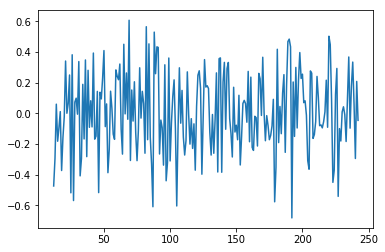

In [125]:
plt.plot(ic_ma_cs)
plt.show()

看起来不是特别直观，我们来计算一下它的20日移动平均，再画图：

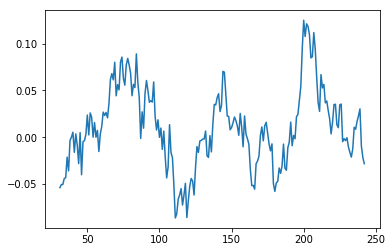

In [129]:
plt.plot(ma_calculator(pd.DataFrame(ic_ma_cs), 20))
plt.show()

我们从图中可以看到，IC还是偏正数，在一年之内有一定反复，但没有明显规律。
我们在结合行情图看看，IC的变化，是否于行情有关：

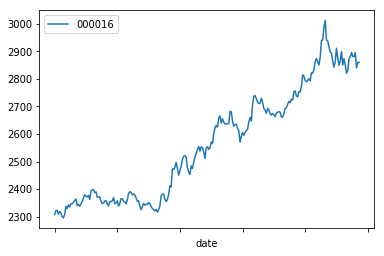

In [132]:
index_close.plot()
plt.show()

和行情对比后，发现IC的变化也无明显规律，看起来，IC还是比较靠谱的，不太随行情变化而变化。
接下来，我们就从面板数据上，综合的计算IC：

In [156]:
ic_ma = np.corrcoef(stock_active_rtn.shift(-1).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor_ma.values.reshape(rtn_predictor_ma.size))[0,1]
print(ic_ma)

0.018161850741592208


这样，我们计算出了IC，看起来还算稳定，0.018，不高不低，可以将就使用。

### 4.4.4 步骤四：计算精炼预测$\alpha$

在以上的实验中，我们获得了计算精炼预测的所有参数，现在，我们可以轻易计算精炼预测$\alpha$了：
$$\alpha = IC \cdot \frac{\mathbf{Std}_{CS}[g_n]}{c} \cdot z_{CS}$$

In [157]:
alpha_ma = ic_ma / stock_ma_c * rtn_predictor_ma
print(alpha_ma.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.578372 -0.785526  0.146804  0.206029  2.097294 -0.387446   
2017-12-26 -0.859866 -0.785526 -0.265767  0.449753  2.097294 -0.206029   
2017-12-27 -0.645201 -0.513314 -0.449753  0.859866  2.097294 -0.146804   
2017-12-28 -0.449753 -0.513314  0.387446  1.107005  2.097294  0.265767   
2017-12-29 -0.146804 -0.449753  0.714125  1.019786  1.414393  0.029290   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.859866  1.864745 -1.540686  0.513314    ...    -1.864745   
2017-12-26  0.859866  2.457265 -1.540686  0.513314    ...    -1.864745   
2017-12-27  0.937714  2.457265 -1.540686  0.146804    ...    -1.864745   
2017-12-28  0.326181  2.457265 -1.540686 -0.087940    ...    -1.864745   
2017-12-29 -0.265767  2.457265 -1.687

## 4.5 延伸阅读——SciPy

在本节中，我们将简要介绍Python软件包SciPy。

SciPy是一个基于Python的软件包，它包含一系列工具箱，致力于解决科学计算中的常见问题。它的不同子模块对应与不同领域的应用，例如插值、积分、优化、图像处理、统计等等。

它的功能不亚于其它标准科学计算程序库，例如基于C/C++的GSL，或者Matlab工具箱。它是Python中科学计算程序的核心包，它用于有效的计算numpy矩阵，让numpy和scipy协同工作。

在实现一个科学计算前，有必要先检查一下是否可以直接使用SciPy提供的方法解决问题。我们常常喜欢从头造轮子，这是非常不好的。SciPy稳定、可靠、高效，应尽可能的使用。

我们来看看SciPy的常用模块：
1. scipy.cluster 聚类
2. scipy.constants 物理/数学常数
3. scipy.fftpack 傅里叶变换
4. scipy.integrate 积分
5. scipy.interpolate 插值
6. scipy.io 输入输出
7. scipy.linalg 线性代数
8. scipy.ndimage n维图像
9. scipy.odr 正交距离回归
10. scipy.optimize 优化
11. scipy.signal 信号处理
12. scipy.sparse 稀疏矩阵
13. scipy.spatial 空间数据结构和算法
14. scipy.special 特殊数学函数
15. scipy.stats 统计

对我们来说，最常用的莫过于scipy.stats统计，有时也会用到scipy.linalg线性代数和scipy.optimize优化。

由于其函数太多，太过于复杂，我们不能一一介绍。
正确的学习方法也绝非直接阅读其手册。

我们建议，每当遇到科学计算的问题时，就去SciPy对应模块的手册中检索，看看它是否提供了解决问题的工具。如果有，在专项的仔细学习这个工具，并使用之。我们不是机器，储存scipy手册的工作不应由我们来做，我们只需要知道它在哪里即可。
它就在这里：

https://www.scipy.org/